#Import the dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Sequential, Conv3D, LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, LSTM #added LSTM import
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import os
import random


In [ ]:
import os
dataset_path = '/content/drive/MyDrive/Classes'
if not os.path.exists(dataset_path):
    !pip install gdown --upgrade
    !gdown --id 1L-anVufTEoQ70SqrSbLshgf8D62uQjb- -O Classes.zip
    !unzip Classes.zip
    !mv Classes /content/drive/MyDrive/

In [ ]:
data_dir = dataset_path

#Video Capture Initialization

In [ ]:
def extract_frames(video_path, num_frames=8, resize_shape=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames).astype(int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, resize_shape)
            frames.append(frame)
        else:
            break
    cap.release()
    return np.array(frames) / 255.0  # normalize frames


Load the data

In [ ]:
def load_ucf101_data(data_dir, num_classes=10, num_frames=8):
    X, y = [], []
    class_dirs = sorted(os.listdir(data_dir))[:num_classes]  # limit to 10 classes for simplicity
    label_map = {class_name: index for index, class_name in enumerate(class_dirs)}

    for class_name in class_dirs:
        class_folder = os.path.join(data_dir, class_name)
        videos = os.listdir(class_folder)

        for video in videos:
            video_path = os.path.join(class_folder, video)
            frames = extract_frames(video_path, num_frames)
            if len(frames) == num_frames:  # ensure we have the right frame count
                X.append(frames)
                y.append(label_map[class_name])  # Use the label from the mapping

    X = np.array(X)
    y = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    return X, y, label_map  # Return the label map as well


In [ ]:
print(f"Dataset path: {dataset_path}")
print(f"Contents of dataset path: {os.listdir(dataset_path)}")

Dataset path: /content/drive/MyDrive/Classes
Contents of dataset path: ['Fencing', 'SumoWrestling', 'ThrowDiscus', 'WallPushups', 'MilitaryParade', 'LongJump', 'RockClimbingIndoor', 'JavelinThrow', 'BoxingPunchingBag', 'Punch']


In [ ]:
data_dir = dataset_path # Replace with actual path
X, y, label_map = load_ucf101_data(data_dir, num_classes=10)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
print(f"Label map: {label_map}")  # Optional: print the label map to see the folder-to-label mapping


Data shape: (600, 8, 128, 128, 3), Labels shape: (600, 10)
Label map: {'BoxingPunchingBag': 0, 'Fencing': 1, 'JavelinThrow': 2, 'LongJump': 3, 'MilitaryParade': 4, 'Punch': 5, 'RockClimbingIndoor': 6, 'SumoWrestling': 7, 'ThrowDiscus': 8, 'WallPushups': 9}


In [ ]:
from tensorflow.keras.layers import LSTM, TimeDistributed  # Import LSTM and TimeDistributed

input_shape = (8, 128, 128, 3)  # 8 frames of 128x128 RGB images
num_classes = 10
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Pool only spatial dimensions

model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Pool only spatial dimensions

model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Pool only spatial dimensions

# Reshape output for LSTM
model.add(TimeDistributed(Flatten()))  # Flatten spatial dimensions for each frame
model.add(LSTM(128))  # Add LSTM layer to process temporal features

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy']) #learning rate changed to 0.0001
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 8, 128, 128, 32)     │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 8, 64, 64, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 8, 64, 64, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 8, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 8, 32, 32, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 8, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 32768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │      16,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,193,738 (65.59 MB)

 Trainable params: 17,193,738 (65.59 MB)

 Non-trainable params: 0 (0.00 B)

#Video Capture Results


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}")


Training shape: (480, 8, 128, 128, 3), Validation shape: (120, 8, 128, 128, 3)


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=4)


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1242 - loss: 2.2863 - val_accuracy: 0.3250 - val_loss: 2.0820
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.3878 - loss: 1.8196 - val_accuracy: 0.4250 - val_loss: 1.5960
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6324 - loss: 1.2582 - val_accuracy: 0.6333 - val_loss: 1.2100
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7149 - loss: 0.9791 - val_accuracy: 0.6417 - val_loss: 1.0196
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.7806 - loss: 0.7134 - val_accuracy: 0.7917 - val_loss: 0.7725
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8881 - loss: 0.4837 - val_accuracy: 0.8083 - val_loss: 0.6340
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9088 - loss: 0.3296 - val_accuracy: 0.8500 - val_loss: 0.5478
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9676 - loss: 0.2092 - val_a

In [ ]:
model.save("activity_recognition_model.keras") # Save the model using .keras format


In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.8621 - loss: 0.4468
Validation Loss: 0.4833865463733673, Validation Accuracy: 0.8583333492279053


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


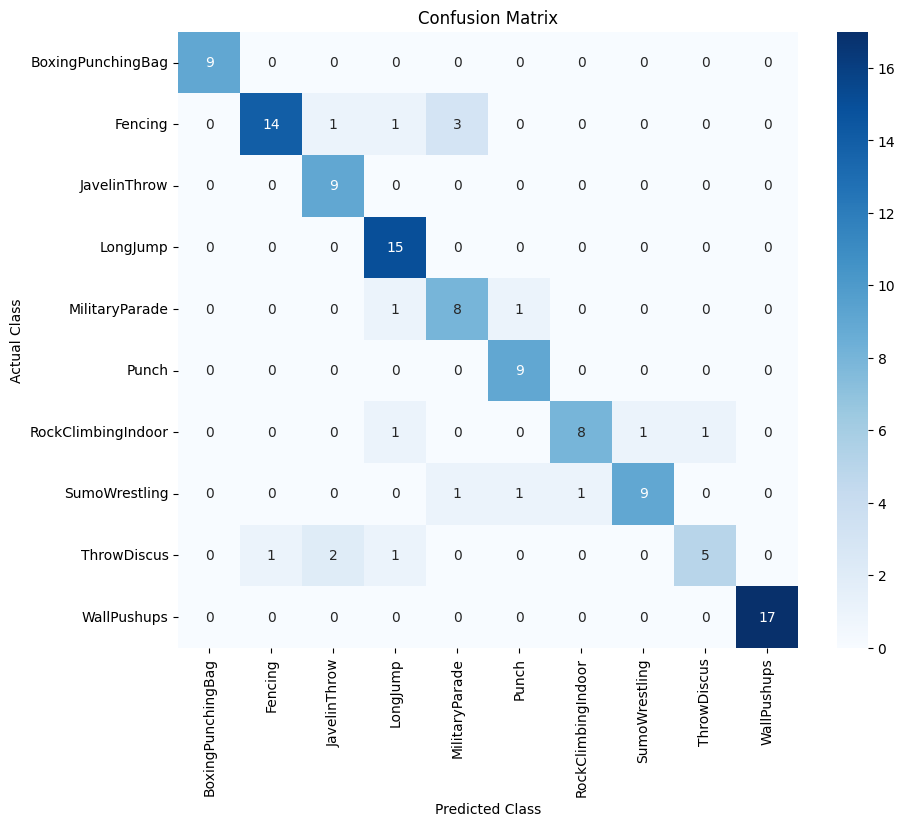

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)  # Predictions on validation data
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map, yticklabels=label_map)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Overall Accuracy: {overall_accuracy}")

# Calculate per-class precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)

# Print per-class metrics
for i, class_name in enumerate(label_map):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")

# Calculate and print macro-averaged precision and recall
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
print(f"\nMacro-averaged Precision: {macro_precision:.4f}")
print(f"Macro-averaged Recall: {macro_recall:.4f}")

Overall Accuracy: 0.8583333333333333
Class: BoxingPunchingBag
  Precision: 1.0000
  Recall: 1.0000
Class: Fencing
  Precision: 0.9333
  Recall: 0.7368
Class: JavelinThrow
  Precision: 0.7500
  Recall: 1.0000
Class: LongJump
  Precision: 0.7895
  Recall: 1.0000
Class: MilitaryParade
  Precision: 0.6667
  Recall: 0.8000
Class: Punch
  Precision: 0.8182
  Recall: 1.0000
Class: RockClimbingIndoor
  Precision: 0.8889
  Recall: 0.7273
Class: SumoWrestling
  Precision: 0.9000
  Recall: 0.7500
Class: ThrowDiscus
  Precision: 0.8333
  Recall: 0.5556
Class: WallPushups
  Precision: 1.0000
  Recall: 1.0000

Macro-averaged Precision: 0.8580
Macro-averaged Recall: 0.8570


In [ ]:
def classify_new_video(model, video_path, num_frames=8, resize_shape=(128, 128), label_map=None):
    frames = extract_frames(video_path, num_frames, resize_shape)
    if frames.shape[0] == num_frames:
        frames = np.expand_dims(frames, axis=0)  # Add batch dimension
        predictions = model.predict(frames)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_name = [k for k, v in label_map.items() if v == predicted_class_index][0]
        return predicted_class_name
    else:
        return "Invalid video: not enough frames"


#Video Predictions

In [ ]:
new_video_path = '/content/drive/MyDrive/UCF-101/RockClimbingIndoor/v_RockClimbingIndoor_g21_c03.avi'
predicted_class = classify_new_video(model, new_video_path, label_map=label_map)
print(f"The new video belongs to class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
The new video belongs to class: RockClimbingIndoor


In [ ]:
new_video_path = '/content/drive/MyDrive/UCF-101/BoxingPunchingBag/v_BoxingPunchingBag_g24_c07.avi'
predicted_class = classify_new_video(model, new_video_path, label_map=label_map)
print(f"The new video belongs to class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The new video belongs to class: MilitaryParade


In [ ]:
new_video_path = '/content/drive/MyDrive/UCF-101/JavelinThrow/v_JavelinThrow_g23_c05.avi'
predicted_class = classify_new_video(model, new_video_path, label_map=label_map)
print(f"The new video belongs to class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The new video belongs to class: JavelinThrow


In [ ]:
new_video_path = '/content/drive/MyDrive/NewVideo/running.avi'
predicted_class = classify_new_video(model, new_video_path, label_map=label_map)
print(f"The new video belongs to class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The new video belongs to class: SumoWrestling
